# Amazon Fine Food Reviews Analysis


Data Source: https://www.kaggle.com/snap/amazon-fine-food-reviews <br>

EDA: https://nycdatascience.com/blog/student-works/amazon-fine-foods-visualization/


The Amazon Fine Food Reviews dataset consists of reviews of fine foods from Amazon.<br>

Number of reviews: 568,454<br>
Number of users: 256,059<br>
Number of products: 74,258<br>
Timespan: Oct 1999 - Oct 2012<br>
Number of Attributes/Columns in data: 10 

Attribute Information:

1. Id
2. ProductId - unique identifier for the product
3. UserId - unqiue identifier for the user
4. ProfileName
5. HelpfulnessNumerator - number of users who found the review helpful
6. HelpfulnessDenominator - number of users who indicated whether they found the review helpful or not
7. Score - rating between 1 and 5
8. Time - timestamp for the review
9. Summary - brief summary of the review
10. Text - text of the review


#### Objective:
Given a review, determine whether the review is positive (rating of 4 or 5) or negative (rating of 1 or 2).

<br>
[Q] How to determine if a review is positive or negative?<br>
<br> 
[Ans] We could use Score/Rating. A rating of 4 or 5 can be cosnidered as a positive review. A rating of 1 or 2 can be considered as negative one. A review of rating 3 is considered nuetral and such reviews are ignored from our analysis. This is an approximate and proxy way of determining the polarity (positivity/negativity) of a review.




# [1]. Reading Data

## [1.1] Loading the data

The dataset is available in two forms
1. .csv file
2. SQLite Database

In order to load the data, We have used the SQLITE dataset as it is easier to query the data and visualise the data efficiently.
<br> 

Here as we only want to get the global sentiment of the recommendations (positive or negative), we will purposefully ignore all Scores equal to 3. If the score is above 3, then the recommendation wil be set to "positive". Otherwise, it will be set to "negative".

In [1]:
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")


import sqlite3
import pandas as pd
import numpy as np
import nltk
import string
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import roc_curve, auc
from nltk.stem.porter import PorterStemmer

import re
# Tutorial about Python regular expressions: https://pymotw.com/2/re/
import string
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem.wordnet import WordNetLemmatizer

from gensim.models import Word2Vec
from gensim.models import KeyedVectors
import pickle

from tqdm import tqdm
import os

In [2]:
# using SQLite Table to read data.
con = sqlite3.connect('database.sqlite') 

# filtering only positive and negative reviews i.e. 
# not taking into consideration those reviews with Score=3
# SELECT * FROM Reviews WHERE Score != 3 LIMIT 500000, will give top 500000 data points
# you can change the number to any other number based on your computing power

# filtered_data = pd.read_sql_query(""" SELECT * FROM Reviews WHERE Score != 3 LIMIT 500000""", con) 
# for tsne assignment you can take 5k data points

filtered_data = pd.read_sql_query(""" SELECT * FROM Reviews WHERE Score != 3 LIMIT 100000""", con) 

# Give reviews with Score>3 a positive rating(1), and reviews with a score<3 a negative rating(0).
def partition(x):
    if x < 3:
        return 0
    return 1

#changing reviews with score less than 3 to be positive and vice-versa
actualScore = filtered_data['Score']
positiveNegative = actualScore.map(partition) 
filtered_data['Score'] = positiveNegative
print("Number of data points in our data", filtered_data.shape)
filtered_data.head(3)

Number of data points in our data (100000, 10)


,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,1,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,0,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,1,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...


In [3]:
display = pd.read_sql_query("""
SELECT UserId, ProductId, ProfileName, Time, Score, Text, COUNT(*)
FROM Reviews
GROUP BY UserId
HAVING COUNT(*)>1
""", con)

In [4]:
print(display.shape)
display.head()

(80668, 7)


,UserId,ProductId,ProfileName,Time,Score,Text,COUNT(*)
0,#oc-R115TNMSPFT9I7,B007Y59HVM,Breyton,1331510400,2,Overall its just OK when considering the price...,2
1,#oc-R11D9D7SHXIJB9,B005HG9ET0,"Louis E. Emory ""hoppy""",1342396800,5,"My wife has recurring extreme muscle spasms, u...",3
2,#oc-R11DNU2NBKQ23Z,B007Y59HVM,Kim Cieszykowski,1348531200,1,This coffee is horrible and unfortunately not ...,2
3,#oc-R11O5J5ZVQE25C,B005HG9ET0,Penguin Chick,1346889600,5,This will be the bottle that you grab from the...,3
4,#oc-R12KPBODL2B5ZD,B007OSBE1U,Christopher P. Presta,1348617600,1,I didnt like this coffee. Instead of telling y...,2


In [5]:
display[display['UserId']=='AZY10LLTJ71NX']

,UserId,ProductId,ProfileName,Time,Score,Text,COUNT(*)
80638,AZY10LLTJ71NX,B006P7E5ZI,"undertheshrine ""undertheshrine""",1334707200,5,I was recommended to try green tea extract to ...,5


In [6]:
display['COUNT(*)'].sum()

393063

#  [2] Exploratory Data Analysis

## [2.1] Data Cleaning: Deduplication

It is observed (as shown in the table below) that the reviews data had many duplicate entries. Hence it was necessary to remove duplicates in order to get unbiased results for the analysis of the data.  Following is an example:

In [7]:
display= pd.read_sql_query("""
SELECT *
FROM Reviews
WHERE Score != 3 AND UserId="AR5J8UI46CURR"
ORDER BY ProductID
""", con)
display.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,78445,B000HDL1RQ,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
1,138317,B000HDOPYC,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
2,138277,B000HDOPYM,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
3,73791,B000HDOPZG,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
4,155049,B000PAQ75C,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...


As it can be seen above that same user has multiple reviews with same values for HelpfulnessNumerator, HelpfulnessDenominator, Score, Time, Summary and Text and on doing analysis it was found that <br>
<br> 
ProductId=B000HDOPZG was Loacker Quadratini Vanilla Wafer Cookies, 8.82-Ounce Packages (Pack of 8)<br>
<br> 
ProductId=B000HDL1RQ was Loacker Quadratini Lemon Wafer Cookies, 8.82-Ounce Packages (Pack of 8) and so on<br>

It was inferred after analysis that reviews with same parameters other than ProductId belonged to the same product just having different flavour or quantity. Hence in order to reduce redundancy it was decided to eliminate the rows having same parameters.<br>

The method used for the same was that we first sort the data according to ProductId and then just keep the first similar product review and delelte the others. for eg. in the above just the review for ProductId=B000HDL1RQ remains. This method ensures that there is only one representative for each product and deduplication without sorting would lead to possibility of different representatives still existing for the same product.

In [8]:
#Sorting data according to ProductId in ascending order
sorted_data=filtered_data.sort_values('ProductId', axis=0, ascending=True, inplace=False, kind='quicksort', na_position='last')

In [9]:
#Deduplication of entries
final=sorted_data.drop_duplicates(subset={"UserId","ProfileName","Time","Text"}, keep='first', inplace=False)
final.shape

(87775, 10)

In [10]:
#Checking to see how much % of data still remains
(final['Id'].size*1.0)/(filtered_data['Id'].size*1.0)*100

87.775

<b>Observation:-</b> It was also seen that in two rows given below the value of HelpfulnessNumerator is greater than HelpfulnessDenominator which is not practically possible hence these two rows too are removed from calcualtions

In [11]:
display= pd.read_sql_query("""
SELECT *
FROM Reviews
WHERE Score != 3 AND Id=44737 OR Id=64422
ORDER BY ProductID
""", con)

display.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,64422,B000MIDROQ,A161DK06JJMCYF,"J. E. Stephens ""Jeanne""",3,1,5,1224892800,Bought This for My Son at College,My son loves spaghetti so I didn't hesitate or...
1,44737,B001EQ55RW,A2V0I904FH7ABY,Ram,3,2,4,1212883200,Pure cocoa taste with crunchy almonds inside,It was almost a 'love at first bite' - the per...


In [12]:
final=final[final.HelpfulnessNumerator<=final.HelpfulnessDenominator]

In [13]:
#Before starting the next phase of preprocessing lets see the number of entries left
print(final.shape)

#How many positive and negative reviews are present in our dataset?
final['Score'].value_counts()

(87773, 10)


1    73592
0    14181
Name: Score, dtype: int64

#  [3] Preprocessing

## [3.1].  Preprocessing Review Text

Now that we have finished deduplication our data requires some preprocessing before we go on further with analysis and making the prediction model.

Hence in the Preprocessing phase we do the following in the order below:-

1. Begin by removing the html tags
2. Remove any punctuations or limited set of special characters like , or . or # etc.
3. Check if the word is made up of english letters and is not alpha-numeric
4. Check to see if the length of the word is greater than 2 (as it was researched that there is no adjective in 2-letters)
5. Convert the word to lowercase
6. Remove Stopwords
7. Finally Snowball Stemming the word (it was obsereved to be better than Porter Stemming)<br>

After which we collect the words used to describe positive and negative reviews

In [14]:
# printing some random reviews
sent_0 = final['Text'].values[0]
print(sent_0)
print("="*50)

sent_1000 = final['Text'].values[1000]
print(sent_1000)
print("="*50)

sent_1500 = final['Text'].values[1500]
print(sent_1500)
print("="*50)

sent_4900 = final['Text'].values[4900]
print(sent_4900)
print("="*50)

My dogs loves this chicken but its a product from China, so we wont be buying it anymore.  Its very hard to find any chicken products made in the USA but they are out there, but this one isnt.  Its too bad too because its a good product but I wont take any chances till they know what is going on with the china imports.
The Candy Blocks were a nice visual for the Lego Birthday party but the candy has little taste to it.  Very little of the 2 lbs that I bought were eaten and I threw the rest away.  I would not buy the candy again.
was way to hot for my blood, took a bite and did a jig  lol
My dog LOVES these treats. They tend to have a very strong fish oil smell. So if you are afraid of the fishy smell, don't get it. But I think my dog likes it because of the smell. These treats are really small in size. They are great for training. You can give your dog several of these without worrying about him over eating. Amazon's price was much more reasonable than any other retailer. You can buy a

In [15]:
# remove urls from text python: https://stackoverflow.com/a/40823105/4084039
sent_0 = re.sub(r"http\S+", "", sent_0)
sent_1000 = re.sub(r"http\S+", "", sent_1000)
sent_150 = re.sub(r"http\S+", "", sent_1500)
sent_4900 = re.sub(r"http\S+", "", sent_4900)

print(sent_0)

My dogs loves this chicken but its a product from China, so we wont be buying it anymore.  Its very hard to find any chicken products made in the USA but they are out there, but this one isnt.  Its too bad too because its a good product but I wont take any chances till they know what is going on with the china imports.


In [16]:
# https://stackoverflow.com/questions/16206380/python-beautifulsoup-how-to-remove-all-tags-from-an-element
from bs4 import BeautifulSoup

soup = BeautifulSoup(sent_0, 'lxml')
text = soup.get_text()
print(text)
print("="*50)

soup = BeautifulSoup(sent_1000, 'lxml')
text = soup.get_text()
print(text)
print("="*50)

soup = BeautifulSoup(sent_1500, 'lxml')
text = soup.get_text()
print(text)
print("="*50)

soup = BeautifulSoup(sent_4900, 'lxml')
text = soup.get_text()
print(text)

My dogs loves this chicken but its a product from China, so we wont be buying it anymore.  Its very hard to find any chicken products made in the USA but they are out there, but this one isnt.  Its too bad too because its a good product but I wont take any chances till they know what is going on with the china imports.
The Candy Blocks were a nice visual for the Lego Birthday party but the candy has little taste to it.  Very little of the 2 lbs that I bought were eaten and I threw the rest away.  I would not buy the candy again.
was way to hot for my blood, took a bite and did a jig  lol
My dog LOVES these treats. They tend to have a very strong fish oil smell. So if you are afraid of the fishy smell, don't get it. But I think my dog likes it because of the smell. These treats are really small in size. They are great for training. You can give your dog several of these without worrying about him over eating. Amazon's price was much more reasonable than any other retailer. You can buy a

In [17]:
# https://stackoverflow.com/a/47091490/4084039
import re

def decontracted(phrase):
    # specific
    phrase = re.sub(r"won't", "will not", phrase)
    phrase = re.sub(r"can\'t", "can not", phrase)

    # general
    phrase = re.sub(r"n\'t", " not", phrase)
    phrase = re.sub(r"\'re", " are", phrase)
    phrase = re.sub(r"\'s", " is", phrase)
    phrase = re.sub(r"\'d", " would", phrase)
    phrase = re.sub(r"\'ll", " will", phrase)
    phrase = re.sub(r"\'t", " not", phrase)
    phrase = re.sub(r"\'ve", " have", phrase)
    phrase = re.sub(r"\'m", " am", phrase)
    return phrase

In [18]:
sent_1500 = decontracted(sent_1500)
print(sent_1500)
print("="*50)

was way to hot for my blood, took a bite and did a jig  lol


In [19]:
#remove words with numbers python: https://stackoverflow.com/a/18082370/4084039
sent_0 = re.sub("\S*\d\S*", "", sent_0).strip()
print(sent_0)

My dogs loves this chicken but its a product from China, so we wont be buying it anymore.  Its very hard to find any chicken products made in the USA but they are out there, but this one isnt.  Its too bad too because its a good product but I wont take any chances till they know what is going on with the china imports.


In [20]:
#remove spacial character: https://stackoverflow.com/a/5843547/4084039
sent_1500 = re.sub('[^A-Za-z0-9]+', ' ', sent_1500)
print(sent_1500)

was way to hot for my blood took a bite and did a jig lol


In [21]:
# https://gist.github.com/sebleier/554280
# we are removing the words from the stop words list: 'no', 'nor', 'not'
# <br /><br /> ==> after the above steps, we are getting "br br"
# we are including them into stop words list
# instead of <br /> if we have <br/> these tags would have revmoved in the 1st step

stopwords= set(['br', 'the', 'i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've",\
            "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', \
            'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their',\
            'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', \
            'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', \
            'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', \
            'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after',\
            'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further',\
            'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more',\
            'most', 'other', 'some', 'such', 'only', 'own', 'same', 'so', 'than', 'too', 'very', \
            's', 't', 'can', 'will', 'just', 'don', "don't", 'should', "should've", 'now', 'd', 'll', 'm', 'o', 're', \
            've', 'y', 'ain', 'aren', "aren't", 'couldn', "couldn't", 'didn', "didn't", 'doesn', "doesn't", 'hadn',\
            "hadn't", 'hasn', "hasn't", 'haven', "haven't", 'isn', "isn't", 'ma', 'mightn', "mightn't", 'mustn',\
            "mustn't", 'needn', "needn't", 'shan', "shan't", 'shouldn', "shouldn't", 'wasn', "wasn't", 'weren', "weren't", \
            'won', "won't", 'wouldn', "wouldn't"])

In [22]:
# Combining all the above stundents 
from tqdm import tqdm
preprocessed_reviews = []
# tqdm is for printing the status bar
for sentance in tqdm(final['Text'].values):
    sentance = re.sub(r"http\S+", "", sentance)
    sentance = BeautifulSoup(sentance, 'lxml').get_text()
    sentance = decontracted(sentance)
    sentance = re.sub("\S*\d\S*", "", sentance).strip()
    sentance = re.sub('[^A-Za-z]+', ' ', sentance)
    # https://gist.github.com/sebleier/554280
    sentance = ' '.join(e.lower() for e in sentance.split() if e.lower() not in stopwords)
    preprocessed_reviews.append(sentance.strip())

100%|██████████████████████████████████████████████████████████████████████████| 87773/87773 [01:18<00:00, 1120.60it/s]


In [23]:
preprocessed_reviews[1500]

'way hot blood took bite jig lol'

# [4] Featurization

In [24]:
y=np.array(final['Score'])
X=np.array(preprocessed_reviews)

## [4.3] TF-IDF

TFIDF Vectorizer with max features=3000

In [25]:
max_features=3000

In [26]:
tf_idf_vect = TfidfVectorizer( min_df=10,max_features=max_features)
tf_idf_vect.fit(X)
print("some sample features(unique words in the corpus)",tf_idf_vect.get_feature_names()[0:10])
print('='*50)

X_tfidf = tf_idf_vect.transform(X)
print("the type of count vectorizer ",type(X_tfidf))
print("the shape of out text TFIDF vectorizer ",X_tfidf.get_shape())
print("the number of unique words including both unigrams and bigrams ", X_tfidf.get_shape()[1])

some sample features(unique words in the corpus) ['ability', 'able', 'absolute', 'absolutely', 'acai', 'acceptable', 'according', 'acid', 'acidic', 'acidity']
the type of count vectorizer  <class 'scipy.sparse.csr.csr_matrix'>
the shape of out text TFIDF vectorizer  (87773, 3000)
the number of unique words including both unigrams and bigrams  3000


# [5] Assignment 11: Truncated SVD

<ol>
    <li><strong>Apply Truncated-SVD on only this feature set:</strong>
        <ul>
            <li><font color='red'>SET 2:</font>Review text, preprocessed one converted into vectors using (TFIDF)</li>
    <br>
    <li><strong>Procedure:</strong>
        <ul>
    <li>Take top 2000 or 3000 features from tf-idf vectorizers using idf_ score.</li>
    <li>You need to calculate the co-occurrence matrix with the selected features (Note: X.X^T
doesn’t give the co-occurrence matrix, it returns the covariance matrix, check these
        bolgs <a href='https://medium.com/data-science-group-iitr/word-embedding-2d05d270b285'>blog-1,</a> <a href='https://www.analyticsvidhya.com/blog/2017/06/word-embeddings-count-word2veec/'>blog-2 </a>for more information)</li>
            <li>You should choose the n_components in truncated svd, with maximum explained
variance. Please search on how to choose that and implement them. (hint: plot of
cumulative explained variance ratio)</li>
            <li>After you are done with the truncated svd, you can apply K-Means clustering and choose
the best number of clusters based on elbow method.</li>
            <li> Print out wordclouds for each cluster, similar to that in previous assignment. </li>
            <li>You need to write a function that takes a word and returns the most similar words using
cosine similarity between the vectors(vector: a row in the matrix after truncatedSVD)</li>
        </ul>
    </li>
    <br>
    
</ol>

## Truncated-SVD

### [5.1] Taking top features from TFIDF,<font color='red'> SET 2</font>

In [27]:
# get the coefficients of top features using idf_ score
topfeatures_coeff=np.argsort(tf_idf_vect.idf_)[:max_features][::1]

In [28]:
#Name of top features
features=np.take(tf_idf_vect.get_feature_names(), topfeatures_coeff)
features

array(['not', 'like', 'good', ..., 'zevia', 'ghee', 'bulbs'], dtype='<U14')

### [5.2] Calulation of Co-occurrence matrix

In [29]:
#https://stackoverflow.com/questions/42814452/co-occurrence-matrix-from-list-of-words-in-python/42814963
import numpy as np
import itertools
from scipy.sparse import csr_matrix

def create_co_occurences_matrix(allowed_words, documents):
    print(f"allowed_words:\n{allowed_words}")
    #print(f"documents:\n{documents}")
    word_to_id = dict(zip(allowed_words, range(len(allowed_words))))
    documents_as_ids = [np.sort([word_to_id[w] for w in doc.split() if w in word_to_id]).astype('uint32') 
                        for doc in documents]
    row_ind, col_ind = zip(*itertools.chain(*[[(i, w) for w in doc] for i, doc in enumerate(documents_as_ids)]))
    # use unsigned int for better memory utilization
    data = np.ones(len(row_ind), dtype='uint32')  
    max_word_id = max(itertools.chain(*documents_as_ids)) + 1
    # efficient arithmetic operations with CSR * CSR
    docs_words_matrix = csr_matrix((data, (row_ind, col_ind)), shape=(len(documents_as_ids), max_word_id)) 
    # multiplying docs_words_matrix with its transpose matrix would generate the co-occurences matrix
    words_cooc_matrix = docs_words_matrix.T * docs_words_matrix  
    words_cooc_matrix.setdiag(0)
    print(f"words_cooc_matrix:\n{words_cooc_matrix.todense()}")
    return words_cooc_matrix, word_to_id 

In [30]:
words_cooc_matrix, word_to_id = create_co_occurences_matrix(features,  X)

allowed_words:
['not' 'like' 'good' ... 'zevia' 'ghee' 'bulbs']
words_cooc_matrix:
[[    0 79807 49251 ...   290   215   439]
 [79807     0 20445 ...   184    88    66]
 [49251 20445     0 ...    77    80    62]
 ...
 [  290   184    77 ...     0     0     0]
 [  215    88    80 ...     0     0     0]
 [  439    66    62 ...     0     0     0]]


In [31]:
print(words_cooc_matrix.shape)
print(type(words_cooc_matrix))

(3000, 3000)
<class 'scipy.sparse.csc.csc_matrix'>


In [ ]:
matrix=X_tfidf.T * X_tfidf  

In [53]:
matrix
print(f"words_cooc_matrix:\n{matrix.todense()}")

words_cooc_matrix:
[[5.87180580e+00 9.24736228e-02 4.83976530e-02 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [9.24736228e-02 6.93825128e+01 2.57924154e-01 ... 9.75841586e-02
  1.06642944e-01 2.10117329e-01]
 [4.83976530e-02 2.57924154e-01 1.90515772e+01 ... 0.00000000e+00
  3.24251415e-02 0.00000000e+00]
 ...
 [0.00000000e+00 9.75841586e-02 0.00000000e+00 ... 9.13671769e+00
  7.52616472e-02 0.00000000e+00]
 [0.00000000e+00 1.06642944e-01 3.24251415e-02 ... 7.52616472e-02
  1.24278177e+01 0.00000000e+00]
 [0.00000000e+00 2.10117329e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 1.38998496e+01]]


In [47]:
allowed_words=features
documents=X
word_to_id = dict(zip(allowed_words, range(len(allowed_words))))
documents_as_ids = [np.sort([word_to_id[w] for w in doc.split() if w in word_to_id]).astype('uint32') 
                        for doc in documents]
row_ind, col_ind = zip(*itertools.chain(*[[(i, w) for w in doc] for i, doc in enumerate(documents_as_ids)]))
#     # use unsigned int for better memory utilization
data = np.ones(len(row_ind), dtype='uint32')  
max_word_id = max(itertools.chain(*documents_as_ids)) + 1
#     # efficient arithmetic operations with CSR * CSR
docs_words_matrix = csr_matrix((data, (row_ind, col_ind)), shape=(len(documents_as_ids), max_word_id)) 
#     # multiplying docs_words_matrix with its transpose matrix would generate the co-occurences matrix
#     words_cooc_matrix = docs_words_matrix.T * docs_words_matrix  
#     words_cooc_matrix.setdiag(0)
#     print(f"words_cooc_matrix:\n{words_cooc_matrix.todense()}")
#     return words_cooc_matrix, word_to_id 

In [48]:
max_word_id

3000

In [42]:
len(documents_as_ids)

87773

In [43]:
row_ind, col_ind = zip(*itertools.chain(*[[(i, w) for w in doc] for i, doc in enumerate(documents_as_ids)]))

In [44]:
len(row_ind)

3037278

In [46]:
itertools.chain(*[[(i, w) for w in doc] for i, doc in enumerate(documents_as_ids)])

<b>We got our Cooccurance Matrix of top 3000 feaures </b>

### [5.3] Finding optimal value for number of components (n) to be retained.

In [32]:
from sklearn.decomposition import TruncatedSVD
from sklearn.random_projection import sparse_random_matrix

svd = TruncatedSVD(n_components=20, n_iter=7, random_state=42)
svd.fit(words_cooc_matrix)  

print(svd.explained_variance_ratio_)  
print(svd.explained_variance_ratio_.sum())  

[8.45250210e-01 8.75393915e-02 1.54393945e-02 5.79316153e-03
 4.34211755e-03 4.29109461e-03 3.94707924e-03 2.86815855e-03
 2.28488997e-03 2.03981537e-03 1.47852759e-03 1.36999655e-03
 1.26637268e-03 1.20650695e-03 1.07138207e-03 9.82565052e-04
 9.05476437e-04 7.92059649e-04 7.13644313e-04 6.74286199e-04]
0.984256130511184


In [33]:
# trying PCA givies same result
from sklearn.decomposition import PCA
pca = PCA(svd_solver='randomized', random_state=42)
pca.fit(words_cooc_matrix.todense())
pca.explained_variance_ratio_

array([8.45773041e-01, 8.70511553e-02, 1.54296467e-02, ...,
       1.60049234e-14, 9.38981684e-15, 7.29063038e-32])

Plot of cumulative explained variance ratio

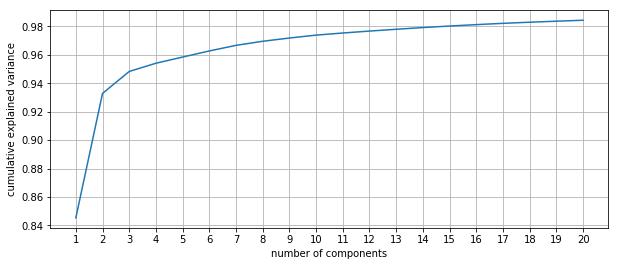

In [34]:
%matplotlib inline
fig = plt.figure(figsize = (10,4))
xi = [i for i in range(1,21)]
plt.plot(xi,np.cumsum(svd.explained_variance_ratio_))
plt.grid(True)
plt.xticks(xi)
plt.xlabel('number of components')
plt.ylabel('cumulative explained variance')
plt.show()

We choose number of components as 3 as after this contribution of each factors becomes less that 0.6%

In [35]:
svd = TruncatedSVD(n_components=3, n_iter=7, random_state=42)
svd.fit(words_cooc_matrix)  

print(svd.explained_variance_ratio_)  
print(svd.explained_variance_ratio_.sum()) 

[0.84525021 0.08753939 0.01543939]
0.9482289961993339


<b> We are able to explain 96.6% of variance hich is quite good </b>

In [36]:
# Transfoming our tfidf vector using truncated SVD
X_SVD=svd.transform(X_tfidf)

### [5.4] Applying k-means clustering

In [84]:
# To perform KMeans clustering 
from sklearn.cluster import KMeans
def KMeansHyperParamter(X_Kmeans):
    # sum of squared distances
    ssd = []
    num_list=[i for i in range(2,20)]
    for num_clusters in tqdm(num_list):
        model_clus = KMeans(n_clusters = num_clusters, max_iter=50)
        model_clus.fit(X_Kmeans)
        ssd.append(model_clus.inertia_)
    plt.plot(num_list,ssd)
    plt.grid(True)
    plt.xlabel("Number of Clusters")
    plt.ylabel("Sum of squared Distances")
    plt.title("Elbow Method")
    plt.show()

In [85]:
def ApplyKmeans(X_Kmeans,N):
    model_clus = KMeans(n_clusters = N, max_iter=300)
    model_clus.fit(X_Kmeans)
    return model_clus.labels_

100%|██████████████████████████████████████████████████████████████████████████████████| 18/18 [03:58<00:00, 25.65s/it]


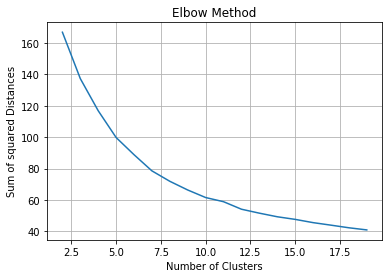

In [86]:
KMeansHyperParamter(X_SVD)

Number of cluster=7 based on elbow method

In [109]:
N=7
Labels1=ApplyKmeans(X_SVD,N)

### [5.5] Wordclouds of clusters obtained in the above section

In [99]:
# https://stackoverflow.com/questions/16645799/how-to-create-a-word-cloud-from-a-corpus-in-python
from wordcloud import WordCloud
def show_wordcloud(data):
    wordcloud = WordCloud(
        background_color='black',
        max_words=100,
#         max_font_size=40, 
#         scale=3,
        random_state=1
    ).generate(str(data))

    fig = plt.figure(1, figsize=(10, 12))
    plt.imshow(wordcloud)
    plt.show()

In [110]:
# Please write all the code with proper documentation
df_cluster= pd.concat([pd.Series(X), pd.Series(Labels1)], axis=1)
df_cluster.columns=["Text","ClusterId"]

In [111]:
df_cluster["ClusterId"].value_counts()

3    45100
6    18637
0    16683
2     4347
1     1874
4      689
5      443
Name: ClusterId, dtype: int64

We see that our each cluster has decent number of points. So our clustering choice seems good

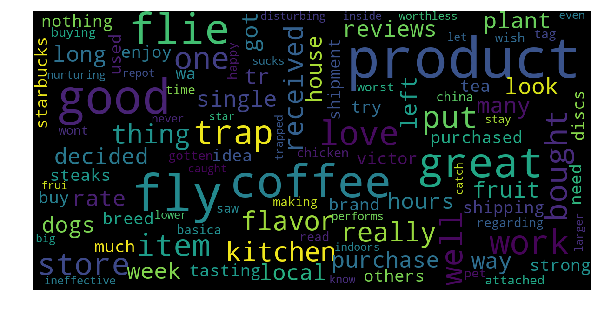

In [50]:
show_wordcloud(df_cluster[df_cluster['ClusterId']==0]['Text'])

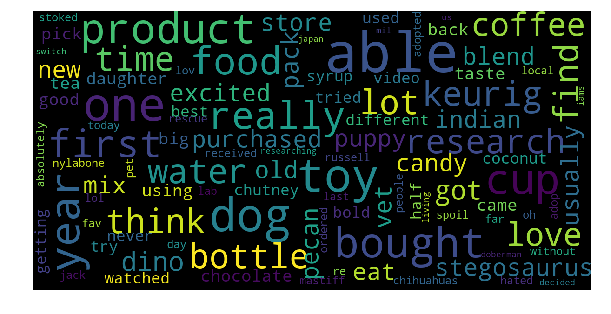

In [51]:
show_wordcloud(df_cluster[df_cluster['ClusterId']==1]['Text'])

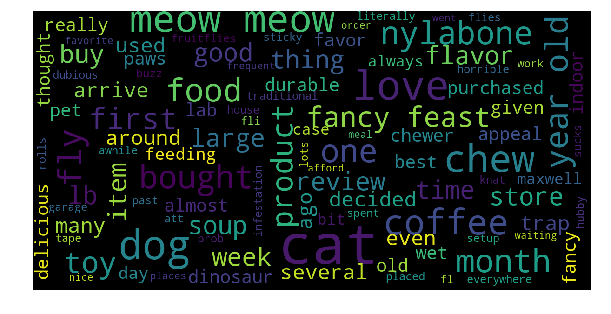

In [52]:
show_wordcloud(df_cluster[df_cluster['ClusterId']==2]['Text'])

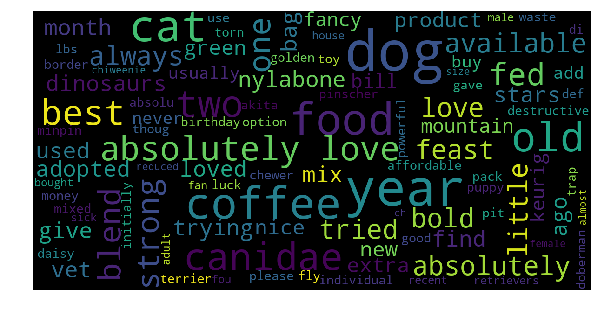

In [53]:
show_wordcloud(df_cluster[df_cluster['ClusterId']==3]['Text'])

### [5.6] Function that returns most similar words for a given word.

svd.components_ gives mapping to convert 2000 dimensional to 3 (number of components) dimension.

In [88]:
Mapping=np.transpose(svd.components_)

In [89]:
import numpy as np
from sklearn.neighbors import NearestNeighbors

#using cosine similarity between the vectors
neigh = NearestNeighbors(n_neighbors=5,metric="cosine")
neigh.fit(Mapping)  

NearestNeighbors(algorithm='auto', leaf_size=30, metric='cosine',
         metric_params=None, n_jobs=1, n_neighbors=5, p=2, radius=1.0)

In [94]:
def similarword(word):
    indexofword=word_to_id[word]
    indexofsimilarword=neigh.kneighbors(Mapping[indexofword].reshape(1, -1), 2, return_distance=False)[0][1]
    similarword=features[indexofsimilarword]
    #print(similarword)
    return similarword

In [95]:
similarword('not')

'cant'

In [96]:
similarword('good')

'type'

In [97]:
similarword('ketchup')

'rinds'

# [6] Conclusions

<br> 1. I have Use a sample size of 100k datapoints.
<br> 2. Took top 2000 features from tf-idf vectorizers using idf_ score.
<br> 3. Calculated the co-occurrence matrix of top 2000 features
<br> 4. Applied truncated SVD and choose the n_components=3 using plot of cumulative explained variance ratio which explained around 95% variance.
<br> 6. Then applied K-Means clustering and choose the best number of clusters=  based on elbow method.
<br> 7. Saw number of reviews in each cluster and printed out wordclouds for each cluster.
<br> 8. Wrote a function 'similarword' that takes a word and returns the most similar words using cosine similarity between the vectors.